In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
data_url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv'
needed_columns = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']

In [21]:
df = pd.read_csv(data_url, usecols=needed_columns)

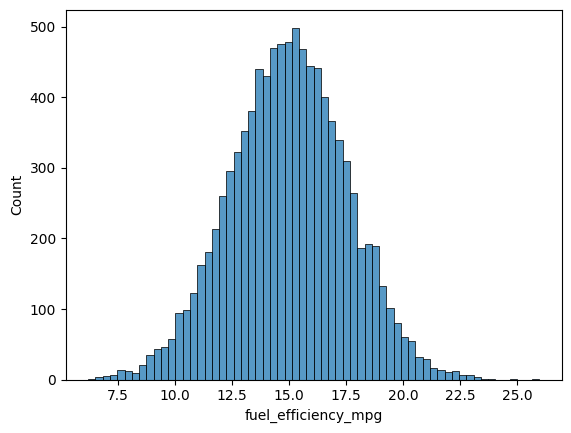

In [22]:
sns.histplot(df.fuel_efficiency_mpg)
plt.show()

## Q1: There's one column with missing values. What is it?

In [23]:
df.columns[df.isna().any()].values[0]

'horsepower'

## Q2: What's the median (50% percentile) for variable 'horsepower'?

In [24]:
float(df.horsepower.median())

149.0

## Prepare and split the dataset

- Shuffle the dataset (the filtered one you created above), use seed 42.
- Split your data in train/val/test sets, with 60%/20%/20% distribution.

In [25]:
def train_validation_test_split(df, train_size=0.6, validation_size=0.2, test_size=0.2, random_state=42):
	df_size = len(df)
	
	np.random.seed(random_state)
	index = np.arange(df_size)
	np.random.shuffle(index)
	
	validation_size = int(validation_size * df_size)
	test_size = int(test_size * df_size)
	train_size = df_size - validation_size - test_size
	
	train_indices = index[:train_size]
	validation_indices = index[train_size:train_size + validation_size]
	test_indices = index[train_size + validation_size:]
	
	df_train = df.iloc[train_indices].reset_index(drop=True)
	df_validation = df.iloc[validation_indices].reset_index(drop=True)
	df_test = df.iloc[test_indices].reset_index(drop=True)
	
	return df_train, df_validation, df_test

## Linear Regression

In [26]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

## Question 3
- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)
- Which option gives better RMSE?

In [27]:
def fill_na_with(df, column, value=0.00):
	df = df.copy()

	df[column] = df[column].fillna(value)
	return df

def get_X_y(df):
	X = df.drop('fuel_efficiency_mpg', axis=1).values
	y = df['fuel_efficiency_mpg'].values

	return X, y

In [28]:
train_df_base, validation_df_base, test_df_base = train_validation_test_split(df)

### Fill NaN values with zero

In [39]:
tain_df = fill_na_with(train_df_base, 'horsepower')
validation_df = fill_na_with(validation_df_base, 'horsepower')

In [40]:
X_train, y_train = get_X_y(tain_df)
X_validation, y_validation = get_X_y(validation_df)

In [41]:
w0, w = train_linear_regression_reg(X_train, y_train, r = 0.00)

In [42]:
y_pred = w0 + X_validation.dot(w)

In [45]:
# RMSE on validation
np.sqrt(np.mean((y_validation - y_pred) ** 2))

np.float64(0.5173782638844466)

### Fill NaN values with mean value

In [46]:
train_df = fill_na_with(train_df_base, 'horsepower', train_df_base.horsepower.mean())
validation_df = fill_na_with(validation_df_base, 'horsepower', train_df_base.horsepower.mean())

In [47]:
X_train, y_train = get_X_y(tain_df)
X_validation, y_validation = get_X_y(validation_df)

In [48]:
w0, w = train_linear_regression_reg(X_train, y_train, r = 0.00)

In [49]:
y_pred = w0 + X_validation.dot(w)

In [50]:
# RMSE on validation
np.sqrt(np.mean((y_validation - y_pred) ** 2))

np.float64(0.5033809143376523)

## Question 4
- Now let's train a regularized linear regression.
- For this question, fill the NAs with 0.
- Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].
- Use RMSE to evaluate the model on the validation dataset.
- Round the RMSE scores to 2 decimal digits.
- Which r gives the best RMSE?

In [51]:
tain_df = fill_na_with(train_df_base, 'horsepower')
validation_df = fill_na_with(validation_df_base, 'horsepower')

In [52]:
X_train, y_train = get_X_y(tain_df)
X_validation, y_validation = get_X_y(validation_df)

In [53]:
# find the best regularization parameter
data = []
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
	w0, w = train_linear_regression_reg(X_train, y_train, r = r)
	y_pred = w0 + X_validation.dot(w)
	rmse = np.sqrt(np.mean((y_validation - y_pred) ** 2))
	data.append((r, rmse))

best_r, best_rmse = min(data, key=lambda x: x[1])
best_r, best_rmse

(0.01, np.float64(0.5171115525769823))

## Question 5
We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
- Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
- For each seed, do the train/validation/test split with 60%/20%/20% distribution.
- Fill the missing values with 0 and train a model without regularization.
- For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
- What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
- Round the result to 3 decimal digits (round(std, 3))

In [54]:
rmses = []

for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
	train_df_base, validation_df_base, test_df_base = train_validation_test_split(df, random_state=seed)
	assert validation_df_base.shape[0] == test_df_base.shape[0]

	train_df = fill_na_with(train_df_base, 'horsepower')
	validation_df = fill_na_with(validation_df_base, 'horsepower')
	X_train, y_train = get_X_y(train_df)
	X_validation, y_validation = get_X_y(validation_df)
	w0, w = train_linear_regression_reg(X_train, y_train, r = 0.00)
	y_pred = w0 + X_validation.dot(w)
	rmse = np.sqrt(np.mean((y_validation - y_pred) ** 2))
	rmses.append(rmse)

np.std(rmses)

np.float64(0.006989446426433706)

## Question 6
- Split the dataset like previously, use seed 9.
- Combine train and validation datasets.
- Fill the missing values with 0 and train a model with r=0.001.
- What's the RMSE on the test dataset?

In [55]:
train_df_base, validation_df_base, test_df_base = train_validation_test_split(df, random_state=9)

In [56]:
full_train_df = pd.concat([train_df_base, validation_df_base]).reset_index(drop=True)

In [57]:
full_train_df.fillna(0, inplace=True)
test_df = test_df_base.fillna(0)

In [58]:
X_full_train, y_full_train = get_X_y(full_train_df)

In [59]:
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r = 0.001)

In [60]:
X_test, y_test = get_X_y(test_df)
y_pred = w0 + X_test.dot(w)
np.sqrt(np.mean((y_test - y_pred) ** 2))

np.float64(0.5156261299169602)